In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import cython

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

In [2]:
# параметры установки
d = 45e-3 # калибр
S = np.pi*d**2/4 # площадь
W_0 = 0.005 # объем каморы
l_d = 4.5 # длина ствола
m_elem = 0.52 # масса МЭ
p_f = 172e6 # давление форсирования

In [3]:
k_r0 = 9.87e8 # предэскп. множитель 
Q_t = 13.4e6 # энергия образования 1 кг продуктов реакций 
E_ign = 0 # энергия воспламенителя
# E_ign = 45e3 # энергия воспламенителя
E_a = 60e3 # энергия активации

In [4]:
v_p0 = 0 # начальная скорость
x_p0 = 0 # начальная координата
p_a = 1e5 # атмосфэрное давление

In [5]:
p_0 = 34.5e6 # начальное давление
T_0 = 300 # начальная температура
R_u = 8.31446262 # универсальная газовая постоянная
hi_O2_and_H2_0 = 1/8 # начальное соотношение мольных долей

In [6]:
mu_H2 = 2e-3 # молярная масса водорода
mu_O2 = 32e-3 # молярная масса кислорода
mu_H2O = 18e-3 # молярная масса воды

In [7]:
%load_ext cython

In [8]:
%%cython
import numpy as np
cimport numpy as np
from cython cimport floating

def C_initial(p_0, W_0, T_0, hi_second_to_first):
    cdef double R_u=8.31446262
    cdef np.ndarray[double, ndim=1] arr

    n_smesi = p_0 * W_0/(R_u * T_0)
    n_first_0 = n_smesi/(hi_second_to_first+1.0)
    return np.array([n_first_0/W_0,
                    n_first_0 * hi_second_to_first/W_0,
                    0])

def foo_k(double T, str gas_name):
    if gas_name == 'H2':
        return 1 + 0.3975 + 0.4814e-4 * T + (-1.073e-7) * T**2 + 4.6863e-11 * T**3 + (-8.5361e-15) * T**4 + 5.6934e-19 * T**5
    elif gas_name == 'O2':
        return 1 + 0.4697 + (-2.9819e-4) * T + 2.0320e-7 * T**2 + (-7.1938e-11) * T**3 + 12.311e-15 * T**4 + (-8.0736e-19) * T**5
    elif gas_name == 'H2O':
        return 1 + 0.3834 + (-1.8579e-4) * T + 0.6266e-7 * T**2 + (-1.0528e-11) * T**3 + 0.93554e-15 * T**4 + (-0.38512e-19) * T**5
    else:
        print('Houston we have a problem')

def k_smesi(double T, double n_H2, double n_O2, double n_H2O):
    help_value = (n_H2/(foo_k(T,'H2')-1) + n_O2/(foo_k(T,'O2')-1) + n_H2O/(foo_k(T,'H2O')-1))**(-1)
    return 1 + n_H2*help_value + n_O2*help_value + n_H2O*help_value

def foo_k_r(double T):
    cdef double k_r0=9.87e8, E_a=60e3, R_u=8.31446262
    return k_r0 * np.e**(-E_a/(R_u*T))

def foo_alpha(double r):
    if abs(r) >= 0.0000001:
        a = 1 - np.e**(-r)
        return (1-a/r)/a
    else:
        return 0.5

def alpha_QSS(np.ndarray[floating, ndim=1] C_n, double T, double dt, double W_n, double W_n_1):
    cdef np.ndarray[floating, ndim=1] P_n, D_n, foo_alpha_res, C_n_kr, D_n_kr
    cdef int i

    P_n = np.array([0, 
                    0, 
                    foo_k_r(T)*C_n[0]*C_n[1]**(1.0/2.0)])

    D_n = np.array([foo_k_r(T)*C_n[1]**(1.0/2.0), 
                    1.0/2.0*foo_k_r(T)*C_n[0]*C_n[1]**(-1.0/2.0),
                    0])

    foo_alpha_res = np.array([0.0,0.0,0.0])

    for i in range(len(D_n)):
        foo_alpha_res[i] = foo_alpha(D_n[i]*dt)

    C_n_kr = W_n/W_n_1 * (C_n + (dt *(P_n-C_n*D_n))/(1.0+foo_alpha_res*D_n*dt))

    if C_n_kr[0] >= 1e-1 and C_n_kr[1] >= 1e-1:
        D_n_kr = (np.array([foo_k_r(T)*C_n_kr[1]**(1/2), 
                            1.0/2*foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(-1/2),
                            0]) + D_n)/2.0
    else:
        D_n_kr = np.array([0.0,0.0,0.0])

    foo_alpha_res = np.array([0.0,0.0,0.0])
    for i in range(len(D_n_kr)):
        foo_alpha_res[i] = foo_alpha(D_n_kr[i]*dt)


    if C_n_kr[0] >= 1e-1 and C_n_kr[1] >= 1e-1:
        P_n_kr = foo_alpha_res*np.array([0, 
                                         0, 
                                         foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(1/2)]) + (1.0-foo_alpha_res)*P_n   
    else:
        P_n_kr = np.array([0.0,0.0,0.0])

    return W_n/W_n_1 * (C_n + (dt *(P_n_kr-C_n*D_n_kr))/(1.0+foo_alpha_res*D_n_kr*dt))

def termodynamic_system(double p_0, double W_0, double T_0, double hi_second_to_first):
    cdef np.ndarray[double, ndim=1] C_n_1, C_n, tau_arr, v_p_arr, p_m_arr, p_b_arr, x_p_arr, T_arr
    cdef double v_p0=0, x_p0=0, l_d=4.5, mu_H2O=18e-3, mu_H2=2e-3, mu_O2=32e-3, m_elem=0.52, Q_t=13.4e6, E_ign=0, R_u=8.31446262, p_f=172e6, p_a=1e5, S=np.pi*(45e-3)**2/4
    cdef int schetchik, falg_fors, flag_dt, count_dt
    # tau, W_n_1, v_p, x_p, T, p_m, value_of_p_gradient, 
    tau = 0 # время от начала процесса
    
    C_n_1 = C_initial(p_0, W_0, T_0, hi_second_to_first) # начальный вектор C
    C_n = C_n_1
    
    # начальный показатель адиабаты
    k_smesi_T_0 = k_smesi(T_0, 
                          C_n[0] * W_0, 
                          C_n[1] * W_0, 
                          C_n[2] * W_0)
    W_n_1 = W_0 # начальный объем
    v_p = v_p0 # начальная скорость
    x_p = x_p0 # начальная координата
    T = T_0 # начальная температура
    p_m = p_0 # начальное давление

    tau_arr = np.array([])
    v_p_arr = np.array([])
    p_m_arr = np.array([])
    p_b_arr = np.array([])
    x_p_arr = np.array([])
    T_arr = np.array([])

    schetchik = 0
    falg_fors = 0
    flag_dt = 0
    p_last = p_0
    count_dt = 0
    value_of_p_gradient = 1e-2
    
    while (x_p <= l_d) and (tau<=7e-3):
        schetchik+=1
                
        if schetchik == 1:
            dt = 1e-8
            count_dt = 0
        elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 0) and (count_dt > 10):
            dt = 1e-9
            flag_dt = 1
            count_dt = 0
        elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 1) and (count_dt > 10):
            dt = 1e-10
            flag_dt = 2
            count_dt = 0
        elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 2) and (count_dt > 10):
            dt = 1e-11
            flag_dt = 3
            count_dt = 0
        elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 3) and (count_dt > 10):
            dt = 1e-12
            flag_dt = 4
            count_dt = 0
        elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 4) and (count_dt > 10):
            dt = 1e-13
            flag_dt = 5
            count_dt = 0
        elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 5) and (count_dt > 10):
            dt = 1e-14
            flag_dt = 6
            count_dt = 0
        elif ((p_m-p_last)/10**6 >= value_of_p_gradient) and (flag_dt == 6) and (count_dt > 10):
            dt = 1e-15
            flag_dt = 7
            count_dt = 0
        elif ((p_m-p_last)/10**6 > 0) and (flag_dt <= 7) and (count_dt > 10) and (p_m/p_0 >= 6.5):
            dt = 5e-16
            flag_dt = 8
            count_dt = 0
        elif ((p_m-p_last)/10**6 > 0) and (flag_dt == 8) and (count_dt > 10) and (p_m/p_0 >= 7.2):
            dt = 1e-16
            flag_dt = 9
            count_dt = 0
            
#         elif ((p_m-p_last)/10**6 >= 5e-4) and (flag_dt == 9) and (count_dt > 10):
#             dt = 1e-18
#             flag_dt = 10
#             count_dt = 0
#         elif ((p_m-p_last)/10**6 >= 5e-4) and (flag_dt == 10) and (count_dt > 10):
#             dt = 1e-19
#             flag_dt = 11
#             count_dt = 0
#         elif ((p_m-p_last)/10**6 >= 5e-4) and (flag_dt == 11) and (count_dt > 10):
#             dt = 1e-20
#             flag_dt = 12
#             count_dt = 0
#         elif ((p_m-p_last)/10**6 >= 5e-4) and (flag_dt == 12) and (count_dt > 10):
#             dt = 1e-21
#             flag_dt = 13
#             count_dt = 0
        elif ((p_m-p_last)/10**6 <= 0) and (flag_dt > 0) and (count_dt > 10):
            dt = 1e-7

            
        count_dt += 1
        
        p_last = p_m
        
        tau += dt

        C_n = C_n_1

        W_n = W_n_1

        M_p = mu_H2O * C_n[2] * W_n

        n_H2 = C_n[0] * W_n
        n_O2 = C_n[1] * W_n
        n_H2O = C_n[2] * W_n

        m_H2 = n_H2 * mu_H2
        m_O2 = n_O2 * mu_O2
        m_H2O = n_H2O * mu_H2O

        n_smesi = n_H2 + n_O2 + n_H2O

        phi = (1+(m_H2 + m_O2 + m_H2O)/(3*m_elem))
        
        p_m = (k_smesi(T, n_H2, n_O2,n_H2O)-1)/W_n * ((p_0*W_0)/(k_smesi_T_0-1) + Q_t*M_p - E_ign - phi/2*m_elem*v_p**2) # среднебаллистическое давление
        
        T = p_m*W_n/(R_u*n_smesi)

        if p_m <= p_f and falg_fors == 0:
            dv_p = 0
        elif p_m <= p_f and falg_fors == 1:
            dv_p = (p_m - p_a)*S/(phi*m_elem) * dt
        elif  p_m > p_f:
            falg_fors = 1
            dv_p = (p_m - p_a)*S/(phi*m_elem) * dt # диф. скорости МЭ

        v_p += dv_p # скорость МЭ

        dx_p = v_p * dt # диф. координаты МЭ

        x_p += dx_p  # координата МЭ

        W_n_1 = W_0 + x_p*S  # Заснарядный объем на n+1 шаге

        W_n = W_0 + (x_p-dx_p)*S # Заснарядный объем на n шаге

        C_n_1 = alpha_QSS(C_n, T, dt, W_n, W_n_1)
        
        p_b = p_m * (1+(m_H2 + m_O2 + m_H2O)/(2*m_elem))/(1+(m_H2 + m_O2 + m_H2O)/(3*m_elem))
               
        if schetchik % 1_000 == 0:
            tau_arr = np.append(tau_arr, tau)
            x_p_arr = np.append(x_p_arr, x_p)
            v_p_arr = np.append(v_p_arr, v_p)
            T_arr = np.append(T_arr, T)
            p_m_arr = np.append(p_m_arr, p_m)
            p_b_arr = np.append(p_b_arr, p_m)
#             print(tau, x_p, v_p, p_m/10**6, (p_m - p_last)/10**6, C_n_1, dt)

    tau_arr = np.append(tau_arr, tau)
    x_p_arr = np.append(x_p_arr, x_p)
    v_p_arr = np.append(v_p_arr, v_p)
    T_arr = np.append(T_arr, T)
    p_m_arr = np.append(p_m_arr, p_m)
    p_b_arr = np.append(p_b_arr, p_m)

    return {'tau':tau_arr, 'x_p':x_p_arr,
           'v_p':v_p_arr, 'T':T_arr, 'p_m':p_m_arr, 'p_b':p_b_arr}

In [20]:
%%time
res = termodynamic_system(p_0, W_0, T_0, 1/8)

Wall time: 6.42 s


In [10]:
df = pd.DataFrame.from_dict(res)

In [11]:
df.head()

,tau,x_p,v_p,T,p_m,p_b
0,0.00001,0.0,0.0,300.142633,3.451619e+07,3.451619e+07
1,0.00002,0.0,0.0,300.287046,3.453258e+07,3.453258e+07
2,0.00003,0.0,0.0,300.433139,3.454916e+07,3.454916e+07
3,0.00004,0.0,0.0,300.580947,3.456594e+07,3.456594e+07
4,0.00005,0.0,0.0,300.730511,3.458291e+07,3.458291e+07


In [12]:
df.shape

(234, 6)

In [13]:
df.p_m.max()/10**6, df.p_b.max()/10**6,df.loc[df.shape[0]-1].v_p

(221.6880645009753, 221.6880645009753, 1671.7484203050647)

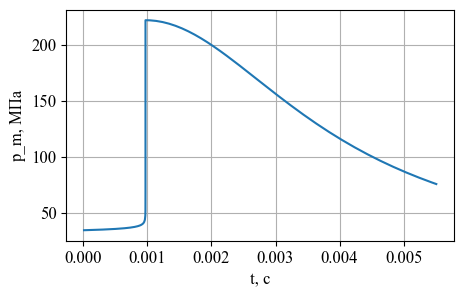

In [14]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df.p_m/10**6)
plt.xlabel('t, с')
plt.ylabel('p_m, МПа')
plt.grid()

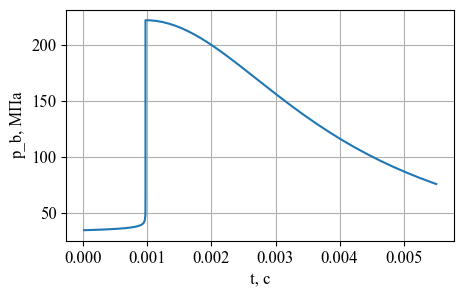

In [15]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df.p_b/10**6)
plt.xlabel('t, с')
plt.ylabel('p_b, МПа')
plt.grid()

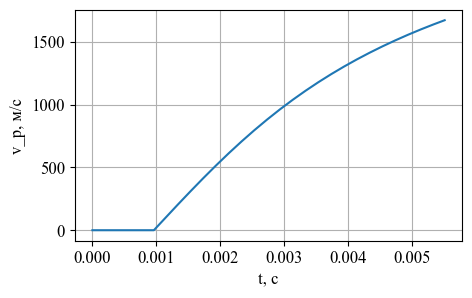

In [16]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df.v_p)
plt.xlabel('t, с')
plt.ylabel('v_p, м/с')
plt.grid()

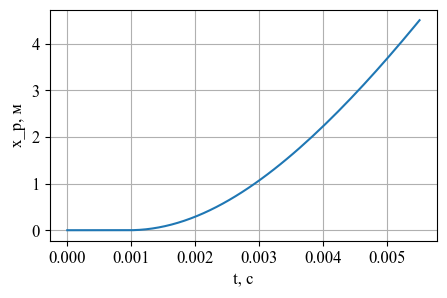

In [17]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df.x_p)
plt.xlabel('t, с')
plt.ylabel('x_p, м')
plt.grid()

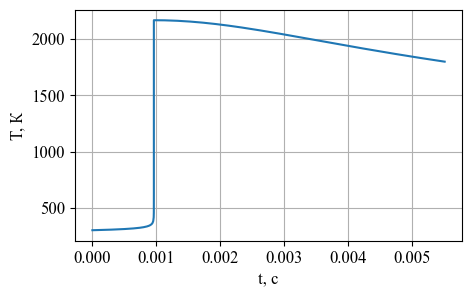

In [18]:
plt.figure(figsize=(5,3))
plt.plot(df.tau, df['T'])
plt.xlabel('t, с')
plt.ylabel('T, К')
plt.grid()